In [4]:
import control as ct
import control2020 as ct20
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
from scipy.io import loadmat

s = sp.var("s") # symbolic variable to represent the laplace space

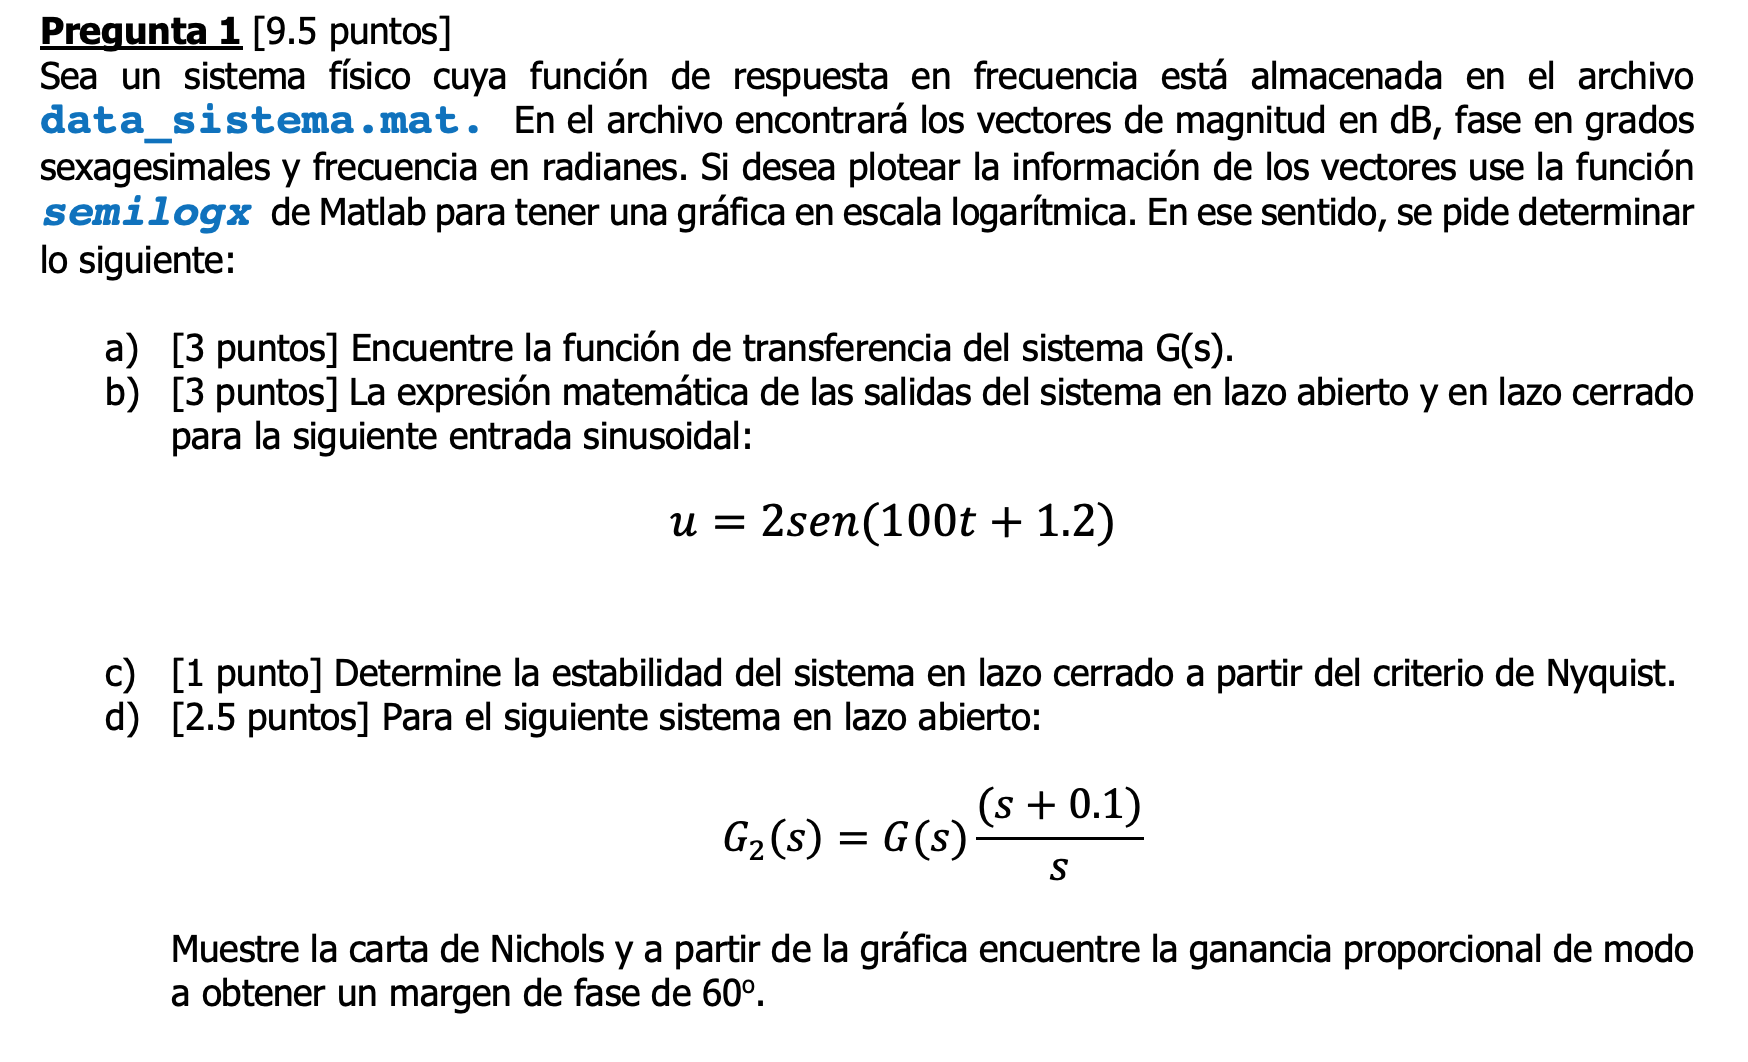

###  a) Encuentre la función de transferencia del sistema G(s).

In [3]:
data_path = "data_sistema.mat"

In [132]:
data = loadmat(data_path)
mag, phase, w = data["Magn"], data["fase"], data["wout"]

mag = mag.reshape([-1, ])
phase = phase.reshape([-1, ])
w = w.reshape([-1, ])

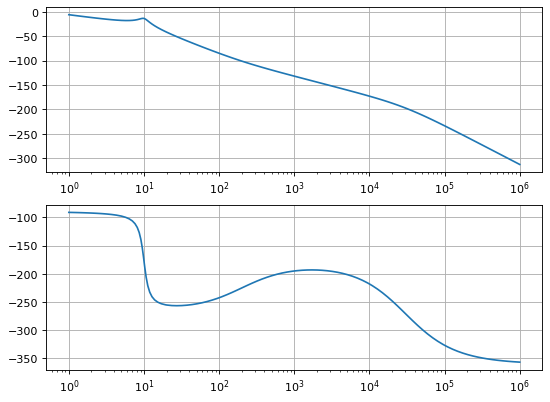

In [50]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(211)
plt.semilogx(w, mag)
plt.grid()

plt.subplot(212)
plt.semilogx(w, phase)
plt.grid()

Usando el diagrama de Bode del sistema lo puedo reconstruir analizando su dinámica y relacionandolo con los polos y zeros que este presenta.

Observo que el sistema cuenta con una ganancia estática, un par de polos complejos conjugados, ...

In [273]:
gain = -10 # approx
wn = 1e1 # approx
g_wn = -6 # approx

K = np.power(10, gain/20)

psi = np.power(10, (gain - g_wn)/20)/2

# zeros
a = 1e2 + 50 # approx

# poles
b = 1e4 + 200 # approx

Reconstruyendo la función de transferencia


                      3.29e+09 s + 4.935e+11
-----------------------------------------------------------------
150 s^4 + 3.061e+06 s^3 + 1.563e+10 s^2 + 9.877e+10 s + 1.561e+12

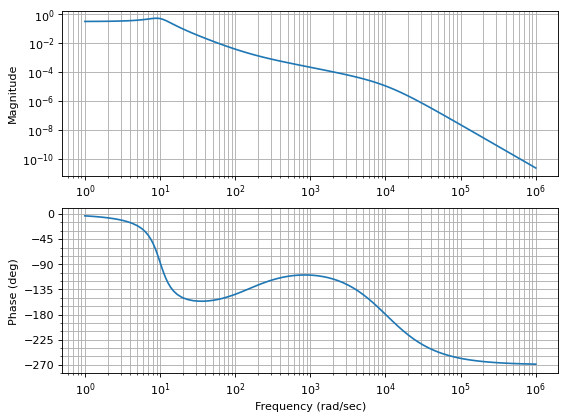

In [274]:
s = ct.TransferFunction([1, 0], [1])
g = K*wn**2/(s**2 + 2*psi*wn*s + wn**2)*(b/(s+b))**2*(s+a)/a
display(g)
plt.figure(num=None, figsize=(8, 6), dpi=80)
_, _, _ = ct.bode(g, w, Plot=True)

He conseguido la función de tranferencia

In [275]:
g


                      3.29e+09 s + 4.935e+11
-----------------------------------------------------------------
150 s^4 + 3.061e+06 s^3 + 1.563e+10 s^2 + 9.877e+10 s + 1.561e+12

Es verdad que no se aproxima en su totalidad y es probable que me falte algún comportamiento que genere un decaimiento general, pero continuaré con esta función de transferencia con los siguientes problemas (por tema de tiempos).

### b) La expresión matemática de las salidas del sistema en lazo abierto y en lazo cerrado para la siguiente entrada sinusoidal
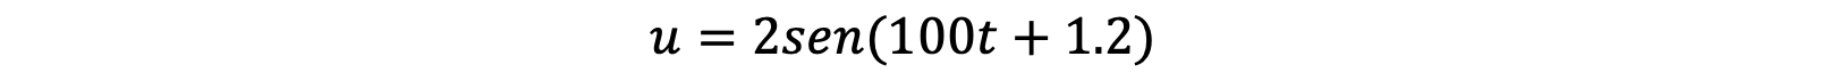

In [294]:
wi = 100
phi = 1.2

mag_at_wi = mag[np.argwhere(w==wi)][0][0]
phase_at_wi = phase[np.argwhere(w==wi)][0][0]

B = np.power(10, mag_at_wi/20) * -2
print(f"B= {B}")

ph0 = phase_at_wi + phi*180/np.pi
ph0 = ph0*np.pi/180
print(f"ph0= {ph0}")

B= -0.00011289830132386125
ph0= -3.031170336494619


Finalmente, la salida al sistema en lazo abierto es:

$$ y = -0.000112\cdot sin(100t-3.03) $$

### c) Determine la estabilidad del sistema en lazo cerrado a partir del criterio de Nyquist.

In [295]:
g


                      3.29e+09 s + 4.935e+11
-----------------------------------------------------------------
150 s^4 + 3.061e+06 s^3 + 1.563e+10 s^2 + 9.877e+10 s + 1.561e+12

In [296]:
g.pole()

array([-1.02000000e+04+1.94824470e-04j, -1.02000000e+04-1.94824470e-04j,
       -3.15478672e+00+9.48932667e+00j, -3.15478672e+00-9.48932667e+00j])

Como se puede apreciar, el sistema no tiene polos inestables.
$$p =0$$

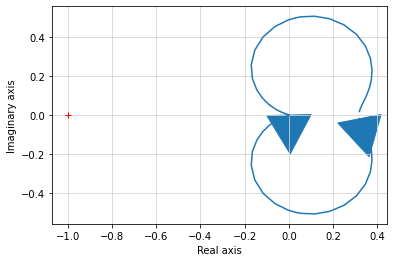

In [299]:
_ = ct.nyquist(g, w)

Como se puede ver, en el gráfico de nyquist, la curva no envuelve al punto -1. Por lo tanto la cantidad de envolvente es 0.

$$ n = 0 $$

Finalmente, sabemos que podemos relacionar la cantidad de polos inestables en el sistema de lazo cerrado a partir de $n$ y $p$, el total de polos inestables se calcula:
$$z = n + p$$

$$z = 0 + 0$$

Ya que $z=0$ podemos decir que el sistema es estable.

### d)
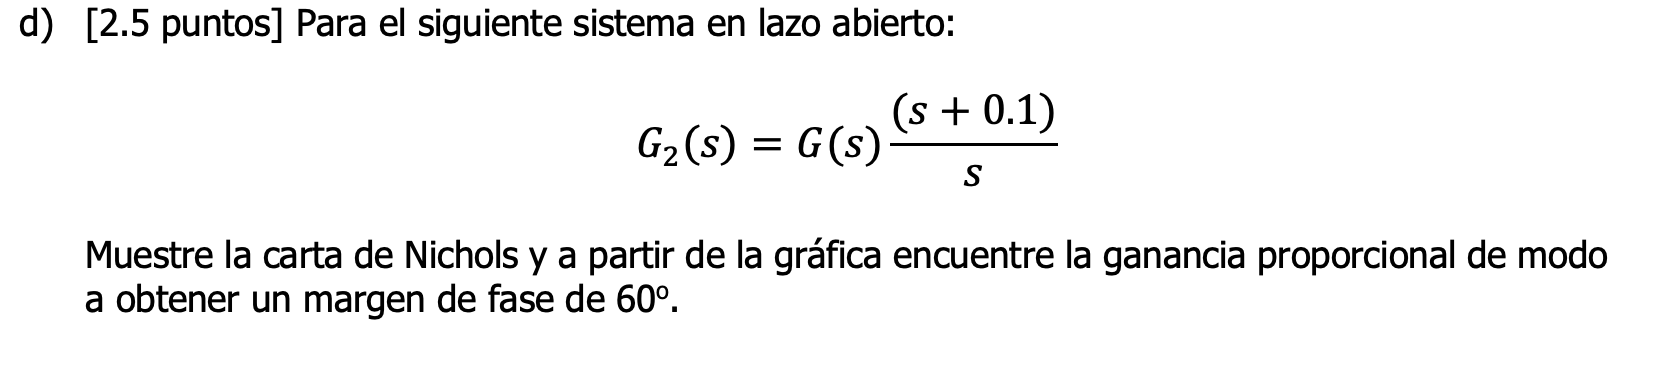

In [301]:
g2 = g*(s+0.1)/s
g2


                3.29e+09 s^2 + 4.938e+11 s + 4.935e+10
---------------------------------------------------------------------
150 s^5 + 3.061e+06 s^4 + 1.563e+10 s^3 + 9.877e+10 s^2 + 1.561e+12 s

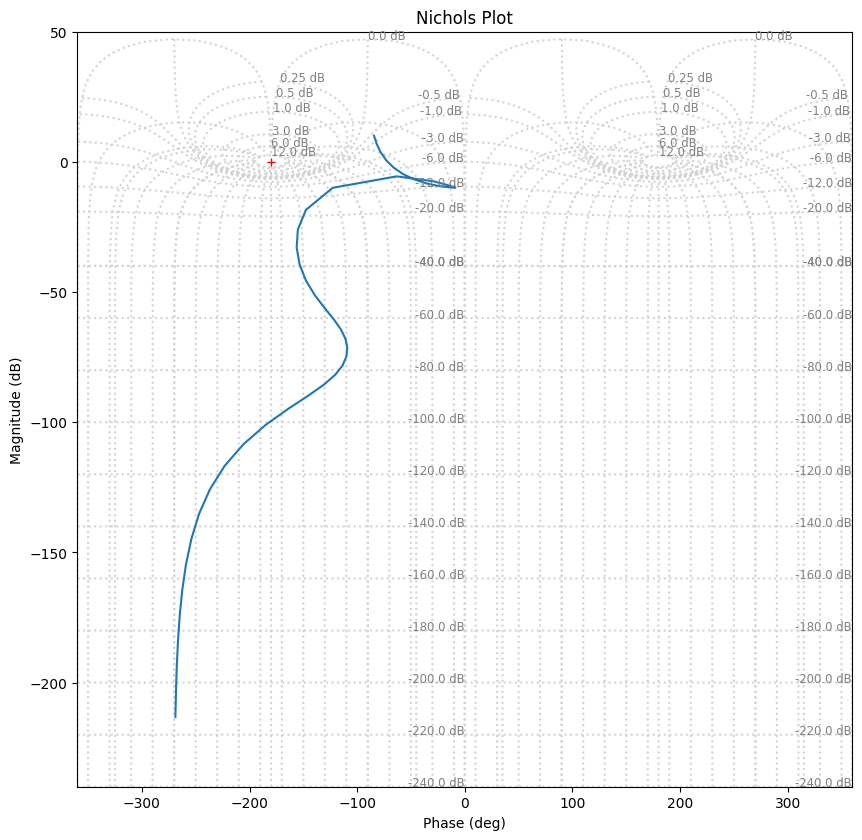

In [304]:
plt.figure(num=None, figsize=(10, 10), dpi=100)
ct.nichols(g2)

---

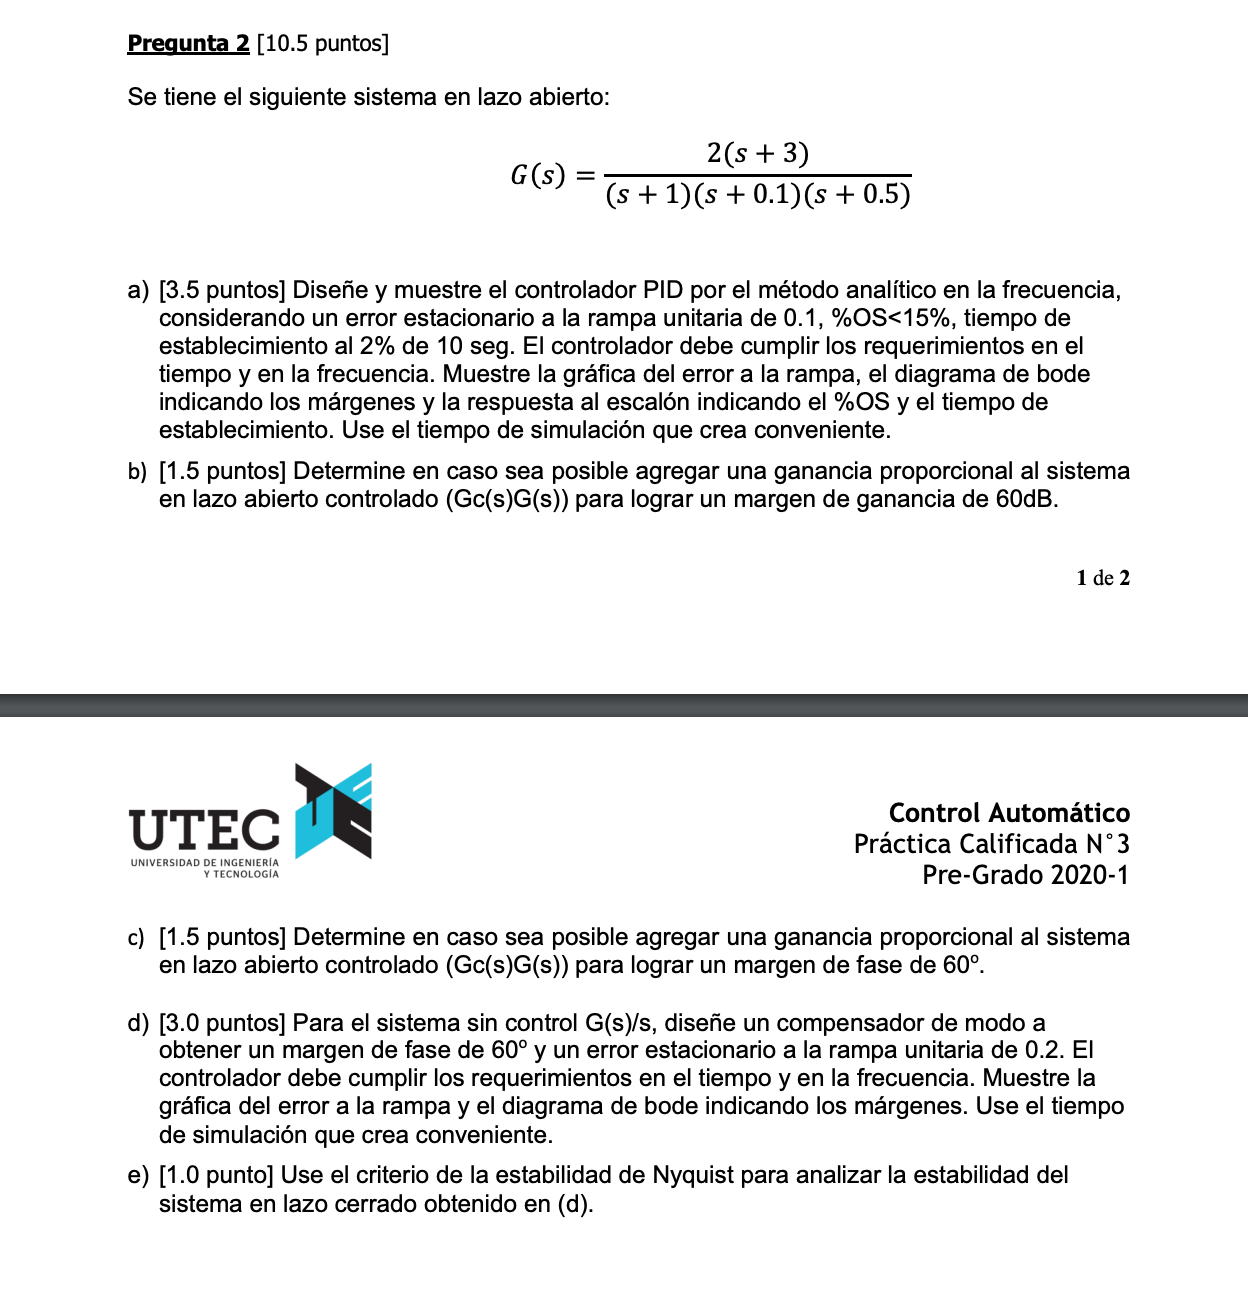

### a) Diseñe y muestre el controlador PID por el método analítico en la frecuencia, considerando un error estacionario a la rampa unitaria de 0.1, %OS<15%, tiempo de establecimiento al 2% de 10 seg. El controlador debe cumplir los requerimientos en el tiempo y en la frecuencia. Muestre la gráfica del error a la rampa, el diagrama de bode indicando los márgenes y la respuesta al escalón indicando el %OS y el tiempo de establecimiento. Use el tiempo de simulación que crea conveniente

In [306]:
g = 2*(s+3)/(s+1)/(s+0.1)/(s+0.5)
g


           2 s + 6
-----------------------------
s^3 + 1.6 s^2 + 0.65 s + 0.05

In [472]:
err_at_ramp = 0.1
po = 3
ts = 3

In [473]:
g_c = g.horner(0)[0][0]
g_c

(120+0j)

In [474]:
ki = 1/g_c/err_at_ramp;
ki

(0.08333333333333333+0j)

In [475]:
psi = np.log(100/po)/np.sqrt(np.pi**2+(np.log(100/po))**2)
wn = 4/psi/ts
m_phase = 100*psi
wc_phase = wn

g_c = g.horner(wc_phase)
g_mag = np.abs(g_c)
g_angle = np.angle(g_c)
k_mag = 1/g_mag

theta_k = -np.pi + m_phase*np.pi/180 - g_angle

kp = k_mag*np.cos(theta_k)
kp = kp[0][0]
kd = (k_mag*np.sin(theta_k) + ki/wc_phase)/wc_phase
kd = kd[0][0]

kp = np.abs(kp)
ki = np.abs(ki)
kd = np.abs(kd)

print("kp=%.2f | ki=%.2f | kd=%.2f"%(kp, ki, kd))

kp=0.34 | ki=0.08 | kd=0.65


In [476]:
pid = kp + kd*s + ki/s
display(pid)


0.6526 s^2 + 0.3373 s + 0.08333
-------------------------------
               s

Como se puede ver, el controlador PID resultante es:
$$ \frac{0.625s^2 + 0.3373s + 0.08333}{s} $$

{'RiseTime': 0.7111337126048953,
 'SettlingTime': 6.513984807460841,
 'SettlingMin': 0.9098205097776957,
 'SettlingMax': 1.1429589587688236,
 'Overshoot': 14.287362757662383,
 'Undershoot': 0.0,
 'Peak': 1.1429589587688236,
 'PeakTime': 1.5644941677307698,
 'SteadyStateValue': 1.0000746637162157}

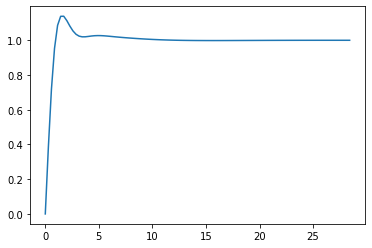

In [477]:
sys = ct.feedback(pid*g, 1)
t, y = ct.step_response(sys)
plt.plot(t, y)
ct.step_info(sys)

$$ PO = 14.28\% $$
$$ Ts = 6.5s $$

(inf, 124.27859514799621, nan, 1.9366102148819273)

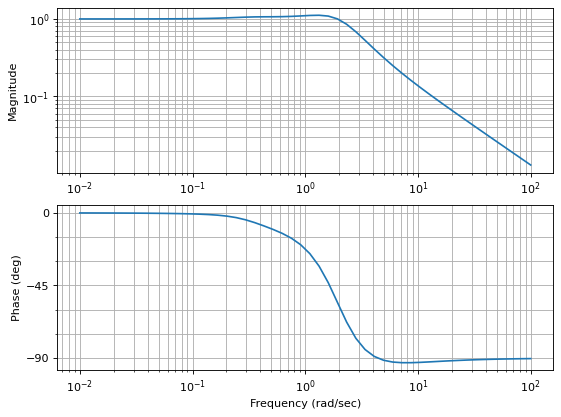

In [480]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = ct.bode(sys)
ct.margin(sys)

$$ Gain margin = inf $$
$$ Phase margin = 124\ deg $$

In [ ]:
# 